In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import integrate
from scipy.spatial.transform import Rotation as R
from scipy.signal import detrend
from itertools import pairwise

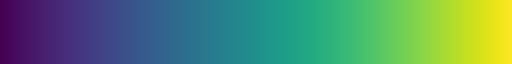

In [4]:
from matplotlib import colormaps
colormaps['viridis']

In [5]:
def read_clean_file(filename):
    data = pd.read_csv(filename, index_col=0)
    data.columns = ['time', 'ax', 'ay', 'az', 'gx', 'gy', 'gz']
    data[['ax', 'ay', 'az']] /= 16384
    data[['ax', 'ay', 'az']] *= 9.80665
    data[['gx', 'gy', 'gz']] /= 16384
    data['a_abs'] = np.sqrt(np.square(data.ax) + np.square(data.ay) + np.square(data.az))
    return data

In [14]:
stand_set_2_file_names = [
    'set2_200hz_sit_stand_stable.csv',
    'set2_200hz_sit_stand_stable2.csv',
    'set2_200hz_sit_stand_stable3.csv',
    'set2_200hz_sit_stand_stable4.csv',
    'set2_200hz_sit_stand_stable5.csv'
]

sit_set_2_file_names = [
    'set2_200hz_stand_sit_stable.csv',
    'set2_200hz_stand_sit_stable2.csv',
    'set2_200hz_stand_sit_stable3.csv',
    'set2_200hz_stand_sit_stable4.csv',
    'set2_200hz_stand_sit_stable5.csv'
]

stand_data_2 = [read_clean_file(name) for name in stand_set_2_file_names]
sit_data_2 = [read_clean_file(name) for name in sit_set_2_file_names]

print(stand_data_2[0].head(10))

           time        ax        ay        az        gx        gy        gz  \
Data set                                                                      
0         13542 -2.851494 -2.366668  9.566033  0.000000  0.000000  0.000000   
1         13677 -2.873042 -2.331952  9.624092  0.000000  0.000000  0.000000   
2         13813 -2.883816 -2.209848  9.517550  0.000000  0.000000  0.000000   
3         13948 -2.948459 -2.255338  9.443330  0.000000  0.000000  0.000000   
4         14083 -2.756325 -2.263119  9.430760  0.000000  0.000000  0.000000   
5         14219 -2.792238 -2.132635  9.355343  0.007507 -0.005859 -0.004700   
6         14354 -2.805406 -2.013524  9.230845  0.007812 -0.006042 -0.004272   
7         14490 -2.800019 -2.062605  9.185953  0.009155 -0.006409 -0.003601   
8         14625 -2.850896 -2.227805  9.183559  0.010254 -0.004883 -0.002014   
9         14760 -2.823961 -2.297236  9.060258  0.010803 -0.003235 -0.000061   

              a_abs  
Data set             
0      

In [19]:
def analyze(data, names):
    for i, (data, file_name) in enumerate(zip(data, names)):
        data1 = data.copy()
        data1.drop(columns='time', inplace=True)
        m100 = lambda x: x[0:100].mean()
        data1['rgx'] = m100(data1.ax) # Resting gravity
        data1['rgy'] = m100(data1.ay)
        data1['rgz'] = m100(data1.az)
        dx = 5.3125 / 1000
        to_rad = lambda x: 1000 * (x * 2*np.pi / 360)
        data1['gx'] = to_rad(data1.gx) # Convert to rads
        data1['gy'] = to_rad(data1.gy)
        data1['gz'] = to_rad(data1.gz)
        data1['gxp'] = integrate.cumulative_trapezoid(data1.gx, dx=dx, initial=0) # gyro x position
        data1['gyp'] = integrate.cumulative_trapezoid(data1.gy, dx=dx, initial=0)
        data1['gzp'] = integrate.cumulative_trapezoid(data1.gz, dx=dx, initial=0)
    
        data1['gR'] = data1.apply(lambda d: (R.from_rotvec([d.gxp, d.gyp, d.gzp])).as_matrix(), axis=1) # gyro Rotation
        rgR = data1.apply(lambda d: np.array([d.rgx, d.rgy, d.rgz]).dot(d.gR), axis=1)
        data1['rgxR'] = rgR.apply(lambda x: x[0]) # resting gravity x Rotated
        data1['rgyR'] = rgR.apply(lambda x: x[1])
        data1['rgzR'] = rgR.apply(lambda x: x[2])
        
        a = data1[['ax', 'ay', 'az']]
        g = data1[['rgxR', 'rgyR', 'rgzR']].to_numpy()
        
        data1['av'] = ((a - g) * g).sum(axis=1) / 9.8
        # data1.av = data1.av.apply(lambda x: x if abs(x) > 1 else 0)
        data1['vv'] = integrate.cumulative_trapezoid(data1.av, dx=dx, initial=0)
        # data1.vv = detrend(data1.vv)
        # data1.vv -= data1.vv.rolling(100).mean().fillna(0)
        data1['vp'] = integrate.cumulative_trapezoid(data1.vv, dx=dx, initial=0)
    
        vv_list = reversed(list(enumerate(data1.vv.to_list())))
        for a,b in pairwise(vv_list):
            if np.sign(a[1]) != np.sign(b[1]):
                root = b[0]
                break
    
        
        # data1['vp'].plot(label=file_name, legend=True, figsize=(10,7 ))
        vp_vars = data1.vp.rolling(100).var().fillna(0).to_list()
        # print(vp_vars)
        # print(max(vp_vars))
        motion_point = vp_vars.index(next(x for x in vp_vars if x > 0.0005))
        # data1['vv'].plot()
        # data1[['vv', 'vp']].plot()
        # data1[['rgxR', 'rgyR', 'rgzR', 'ax', 'ay', 'az']].plot()
        data1[['gxp', 'gyp', 'gzp']].plot()
    
        root = motion_point + 200
    
        # plt.axvline(motion_point, color='g')
        # plt.axvline(root, color='r')
        # plt.show()

        mean_vp = data1['vp'][motion_point:root].mean()
    
        minimax = data1['vp'][root]
        classification = 'Stand' if minimax >= 0 else 'Sit'
        print(f'File name: {file_name}, Peak position: {minimax}, Classification: {classification}, Root: {root}, Motion point: {motion_point}, Mean VP: {mean_vp}')


File name: set2_200hz_sit_stand_stable.csv, Peak position: 0.31779172579195597, Classification: Stand, Root: 682, Motion point: 482, Mean VP: 0.25135830017230565


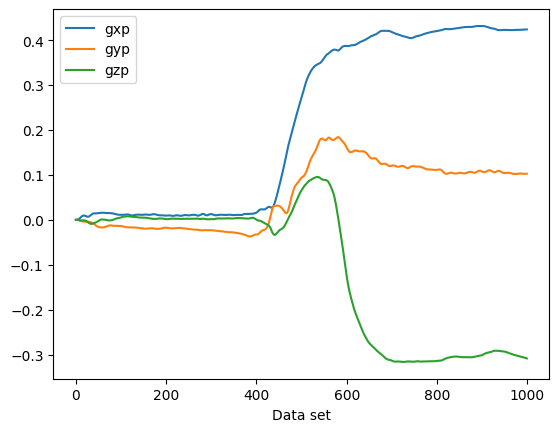

In [20]:
all_data = stand_data_2 + sit_data_2
all_names = stand_set_2_file_names + sit_set_2_file_names

analyze(all_data[0:1], all_names[0:1])

File name: 200hz_sit_stand2.csv, Peak position: -0.847532357953737, Classification: Sit, Root: 775, Motion point: 575


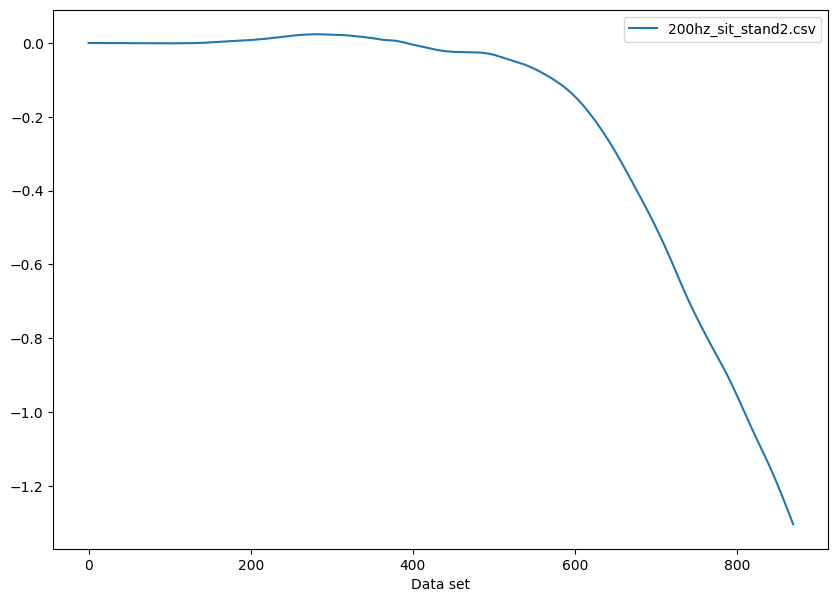

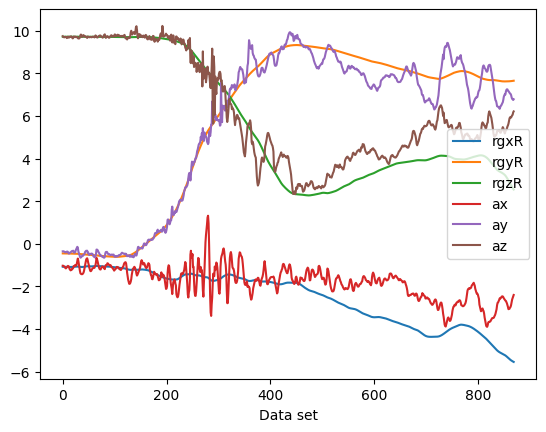

In [255]:
write_stand_filenames = ['200hz_sit_stand2.csv']
wrist_stand_data = [read_clean_file(filename) for filename in write_stand_filenames]

wrist_sit_filenames = ['200hz_stand_sit.csv']
wrist_sit_data = [read_clean_file(filename) for filename in wrist_sit_filenames]

data = analyze(wrist_stand_data, write_stand_filenames)